In [2]:
import boto
from boto.s3.connection import S3Connection

In [3]:
from datetime import date, datetime, timedelta
import os
import pyart
import re


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [133]:
class OrderLevel2(object):
    def __init__(self):
        self._conn = S3Connection(anon=True)
        self._bucket = self._conn.get_bucket('noaa-nexrad-level2')
        
    def select_around(self, station, timestamp, dt=timedelta(minutes=5), debug=False):
        if isinstance(timestamp, str):
            timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M')
            
        min_time = timestamp - dt
        max_time = timestamp + dt
        
        keys = []
        DT_REGEX = r'\d{8}_\d{6}'
        querytimes = (min_time,) if min_time.hour == max_time.hour else (min_time, max_time)
        if debug:
            print('Time range considered: {}'.format(querytimes))
        
        for querytime in querytimes:
            prefix = '{dt:%Y}/{dt:%m}/{dt:%d}/{st}/{st}{dt:%Y%m%d_%H}'.format(
                dt=querytime, st=station)
            
            for key in self._bucket.list(prefix=prefix):
                # e.g. KVNX20120414_192456
                key_datetime = re.search(DT_REGEX, key.name)
                if key_datetime:
                    key_datetime = datetime.strptime(key_datetime.group(0), '%Y%m%d_%H%M%S')
                    
                    t_hi = max(key_datetime, timestamp)
                    t_lo = key_datetime if t_hi is timestamp else timestamp
                    
                    if t_hi - t_lo < dt:
                        if debug:
                            print('Found key: {}'.format(key.name))
                        keys.append(key)
                    else:
                        if debug:
                            print('Skipped key: {}'.format(key.name))
        
        return OrderSelection(keys)
                    
#     def select_range(self, station, timestamp_start, timestamp_end):
        
    def select_hours(self, station, order_date, from_hr=0, to_hr=24):
        if isinstance(order_date, str):
            order_date = datetime.strptime(order_date, '%Y-%m-%d')
            
        keys = []
        for hr in range(from_hr, to_hr):
            prefix = '{dt:%Y}/{dt:%m}/{dt:%d}/{st}/{st}{dt:%Y%m%d}_{hr}'.format(
                dt=order_date, st=station, hr=str(hr).zfill(2))
            keys += list(self._bucket.list(prefix=prefix))
            
        return OrderSelection(keys)
            
            
class OrderSelection(object):
    def __init__(self, keys):
        self._keys = keys
        
    @property
    def items(self):
        return [key.name for key in self._keys]
    
    def __bool__(self):
        return bool(self._keys)
    
    def __getitem__(self, item):
        sublist = self._keys[item]
        if not isinstance(sublist, list):
            sublist = [sublist]
        return OrderSelection(sublist)
    
    def save_to(self, dest, overwrite=False):
        saved_files = []
        for key in self._keys:
            filename = key.name.split('/')[-1]
            targ = os.path.join(dest, filename)
            
            if overwrite or not os.path.isfile(targ):
                key.get_contents_to_filename(targ)
                
            saved_files.append(targ)
        return saved_files
    
#     def __str__(self):
#         return 'OrderSelection(items={})'.format('\n'.join(self.items))

/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-28 02:22:07.512737. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [134]:
order = OrderLevel2()
selection = order.select_around('KVNX', '2012-04-15 00:27')
selection.items

/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-28 02:22:37.559178. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


['2012/04/15/KVNX/KVNX20120415_002301_V06.gz',
 '2012/04/15/KVNX/KVNX20120415_002743_V06.gz']

In [135]:
files = selection[-1].save_to('~/Documents/weatherpy-work/radar')

/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-28 02:22:45.105098. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [136]:
sample = pyart.io.read_nexrad_archive(files[-1])

/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-28 02:22:48.161109. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [23]:
from geopy.distance import VincentyDistance
from geopy import Point

/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-28 01:01:19.493098. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [140]:
pt = Point(*display.loc)

def dest_latlon(point, km, bearing):
    if not isinstance(point, Point):
        point = Point(*point)
    dist = VincentyDistance(kilometers=km)
    dest = dist.destination(point, bearing)
    return dest.latitude, dest.longitude


def bbox_from_loc(loc, km_x, km_y=None):
    if km_y is None:
        ky_y = km_x
        
    lat1, _ = dest_latlon(loc, km_y, 0)
    _, lon1 = dest_latlon(loc, km_x, 90)
    lat0, _ = dest_latlon(loc, km_y, 180)
    _, lon0 = dest_latlon(loc, km_x, 270)

    return (lon0, lon1, lat0, lat1)

latctr, lonctr = display.loc
lon0, lon1, lat0, lat1 = bbox_from_loc((latctr + 0.05, lonctr - 0.15), 100, 75)


# lat1, _ = dest_latlon(pt, 230, 0)
# _, lon1 = dest_latlon(pt, 230, 90)
# lat0, _ = dest_latlon(pt, 230, 180)
# _, lon0 = dest_latlon(pt, 230, 270)

# (lon0, lon1, lat0, lat1)

/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-28 02:26:51.770274. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [64]:
import sys
sys.path.append('..')
from wxdata.plotting import simple_basemap

/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-28 01:29:05.578194. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/Users/jitang/anaconda/envs/basemapenv/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-01-28 02:27:35.231976. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


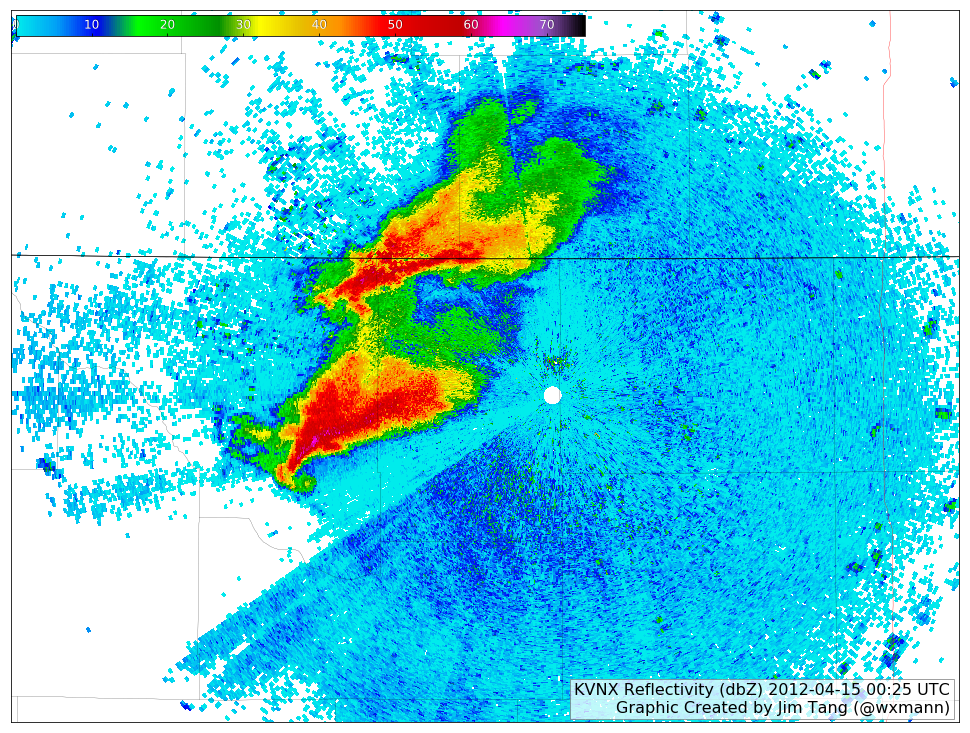

In [142]:
fig = plt.figure(figsize=(18, 16))
display = pyart.graph.RadarMapDisplay(sample)
plotarea = display.plot_ppi_map('reflectivity', title_flag=False, 
                                min_lon=lon0, min_lat=lat0 , max_lon=lon1, max_lat=lat1,
                                vmin=0, vmax=75, resolution='i',
                                embelish=False, colorbar_flag=False)

display.basemap.drawstates()
display.basemap.drawcounties()

from wxdata.plotting import draw_hways, bottom_right_textbox, inset_colorbar
draw_hways(display.basemap)
bottom_right_textbox(display.basemap.ax, 
                     'KVNX Reflectivity (dbZ) 2012-04-15 00:25 UTC\nGraphic Created by Jim Tang (@wxmann)')
inset_colorbar(display.plots[0], display.basemap.ax, tickcolor='white', loc=2)

# display.plot_range_ring(220, linewidth=1, color='gray')